The difference in this part from the previous part is that we are adding more features to train our model off. 
In the previous part, the 5 features that we used were:
1. Number of tweets in that hour
2. Total number of retweets
3. Time of day
4. Sum of number of followers of all users
5. Max number of followers of users

In this part, the features that we are going to use are:
1. Number of tweets in that hour
2. Total number of retweets
3. Time of day
4. Sum of number of followers of all users
5. Max number of followers of users
6. User mentions
7. Hashtags in tweet
8. Reply or not
9. Number of favorites
10. Ranking scores
11. Number of citations
12. Verified User or not


In [32]:
import json
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import Counter

In [33]:
def get_data_and_do_everything(hashtag):
    dictionary = {'#GoHawks' : ['tweets_#gohawks.txt', 188136],
                    '#GoPatriots' : ['tweets_#gopatriots.txt', 26232],
                    '#NFL' : ['tweets_#nfl.txt', 259024],
                    '#Patriots' : ['tweets_#patriots.txt', 489713],
                    '#SB49' : ['tweets_#sb49.txt', 826951],
                    '#SuperBowl' : ['tweets_#superbowl.txt', 1348767]}
    
    time_stamp = np.zeros(dictionary[hashtag][1])
    followers_by_user = np.zeros(dictionary[hashtag][1])
    retweeted = [False] * dictionary[hashtag][1]
    user_mentions = np.zeros(dictionary[hashtag][1])
    hashtags_in_tweet = np.zeros(dictionary[hashtag][1])
    reply = [False] * dictionary[hashtag][1]
    favorite_count = np.zeros(dictionary[hashtag][1])
    verified = [False] * dictionary[hashtag][1]
    number_of_citations = np.zeros(dictionary[hashtag][1])
    ranking_scores = np.zeros(dictionary[hashtag][1])
    
    
    file = open('./tweet_data/'+dictionary[hashtag][0])
    for (line, index) in zip(file, range(0, dictionary[hashtag][1])):
        data = json.loads(line)
        time_stamp[index] = data['citation_date']
        followers_by_user[index] = data['author']['followers']
        author_name = data['author']['nick']
        original_author_name = data['original_author']['nick']
        if original_author_name != author_name:
            retweeted[index] = True
        user_mentions[index] = len(data['tweet']['entities']['user_mentions'])
        hashtags_in_tweet[index] = data['title'].count('#')
        if data['tweet']['in_reply_to_status_id'] != 'null':
            reply[index] = True
        favorite_count[index] = data['tweet']['favorite_count']
        if data['tweet']['user']['verified'] != 'False':
            reply[index] = True
        number_of_citations[index] = len(data['tweet']['entities']['urls'])
        ranking_scores[index] = data['metrics']['ranking_score']

    file.close()
    calculations(time_stamp, followers_by_user, retweeted, user_mentions, hashtags_in_tweet, reply, favorite_count, verified, number_of_citations, ranking_scores, dictionary, hashtag)

In [34]:
def calculations(time_stamp, followers_by_user, retweeted, user_mentions, hashtags_in_tweet, reply, favorite_count, verified, number_of_citations, ranking_scores, dictionary, hashtag):
    hour = int((max(time_stamp)-min(time_stamp))/3600)+1
    hourly_tweet_number = [0]*(hour)
    hourly_retweet_number = [0]*(hour)
    hourly_sum_of_followers = [0]*(hour)
    hourly_max_follower = [0]*(hour)
    time_of_day = [0]*(hour)
    hourly_user_mentions = [0]*(hour)
    hourly_hashtags_in_tweet = [0]*(hour)
    hourly_reply = [0]*(hour)
    hourly_favorite_count = [0]*(hour)
    hourly_verified = [0]*(hour)
    hourly_number_of_citations = [0]*(hour)
    hourly_ranking_scores = [0]*(hour)
    
    start = min(time_stamp)
    for i in range(0, dictionary[hashtag][1]):
        current_hour = int((time_stamp[i] - start)/3600)
        hourly_tweet_number[current_hour] += 1
        if retweeted[i] == True:
            hourly_retweet_number[current_hour] += 1
        hourly_sum_of_followers[current_hour] += followers_by_user[i]
        if followers_by_user[i] > hourly_max_follower[current_hour]:
            hourly_max_follower[current_hour] = followers_by_user[i]
        hourly_user_mentions[current_hour] += user_mentions[i]
        hourly_hashtags_in_tweet[current_hour] += hashtags_in_tweet[i]
        if reply[i] == True:
            hourly_reply[current_hour] += 1
        hourly_favorite_count[current_hour] += favorite_count[i]
        if verified[i] == True:
            hourly_verified[current_hour] += 1
        hourly_number_of_citations[current_hour] += number_of_citations[i]
        hourly_ranking_scores[current_hour] += ranking_scores[i]
        
        for i in range(0, len(time_of_day)):
            time_of_day[i] = i%24
            
    convert_to_df(hourly_tweet_number, hourly_retweet_number, hourly_sum_of_followers, hourly_max_follower, time_of_day, hourly_user_mentions, hourly_hashtags_in_tweet, hourly_reply, hourly_favorite_count, hourly_verified, hourly_number_of_citations, hourly_ranking_scores, hashtag)

In [35]:
def convert_to_df(hourly_tweet_number, hourly_retweet_number, hourly_sum_of_followers, hourly_max_follower, time_of_day, hourly_user_mentions, hourly_hashtags_in_tweet, hourly_reply, hourly_favorite_count, hourly_verified, hourly_number_of_citations, hourly_ranking_scores, hashtag):
    target_value = hourly_tweet_number[1:]
    target_value.append(0)
    full_data = np.array([hourly_tweet_number, hourly_retweet_number, hourly_sum_of_followers, hourly_max_follower, time_of_day, hourly_user_mentions, hourly_hashtags_in_tweet, hourly_reply, hourly_favorite_count, hourly_verified, hourly_number_of_citations, hourly_ranking_scores, target_value])
    full_data = np.transpose(full_data)
    data_frame = DataFrame(full_data)
    data_frame.columns = ['hourly_tweet_number', 'hourly_retweet_number', 'hourly_sum_of_followers', 'hourly_max_follower', 'time_of_day', 'hourly_user_mentions', 'hourly_hashtags_in_tweet', 'hourly_reply', 'hourly_favorite_count', 'hourly_verified', 'hourly_number_of_citations', 'hourly_ranking_scores', 'target_value']
    linear_regression(data_frame, hashtag)

In [36]:
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [37]:
def linear_regression(data_frame, hashtag):
    #need to one hot encode time of day
    training_data = one_hot(data_frame, ['time_of_day'])
    training_data.drop('time_of_day', 1, inplace=True)
    target_data = training_data.pop('target_value')
    linear_reg = LinearRegression(fit_intercept = False)
    linear_regression_fitted = linear_reg.fit(training_data, target_data)
    
    predicted = linear_regression_fitted.predict(training_data)
    RMSE = calculate_RMSE(predicted, target_data)
    print('RMSE is:', RMSE)
    perform_t_test(target_data, training_data)
    plot(training_data, predicted, hashtag)

In [38]:
def calculate_RMSE(predicted, actual):  
    return np.sqrt(np.mean((predicted - actual) ** 2))  

In [39]:
def perform_t_test(target_data, training_data):
    model = sm.OLS(target_data, training_data)
    results = model.fit()
    print(results.summary())

For #GoHawks, the important features are: hourly_tweet_number, hourly_user_mentions, hourly_reply, hourly_number_of_citations, hourly_ranking_scores. 

For #GoPatriots, the important features are: hourly_tweet_number, 
hourly_retweet_number, hourly_sum_of_followers, hourly_max_follower, hourly_user_mentions, hourly_hashtags_in_tweet, hourly_reply, hourly_number_of_citations, hourly_ranking_scores. 

For #NFL, the important features are: hourly_hashtags_in_tweet, hourly_favorite_count, time_of_day_14.0, hourly_number_of_citations, hourly_user_mentions

For #Patriots, the important features are: hourly_tweet_number, hourly_retweet_number, hourly_sum_of_followers, hourly_max_follower, hourly_user_mentions, hourly_hashtags_in_tweet, hourly_reply, hourly_ranking_scores

For #SB49, the important features are: hourly_tweet_number, hourly_sum_of_followers, hourly_max_follower, hourly_user_mentions, hourly_hashtags_in_tweet, hourly_reply, hourly_ranking_scores

For #SuperBowl, the important features are: hourly_tweet_number, hourly_sum_of_followers, hourly_sum_of_followers, hourly_hashtags_in_tweet, hourly_reply, hourly_favorite_count, hourly_ranking_scores

In [40]:
important_feature_list_for_all = ['hourly_tweet_number', 'hourly_user_mentions', 'hourly_reply', 'hourly_number_of_citations', 'hourly_ranking_scores', 'hourly_tweet_number', 'hourly_retweet_number', 'hourly_sum_of_followers', 'hourly_max_follower', 'hourly_user_mentions', 'hourly_hashtags_in_tweet', 'hourly_reply', 'hourly_number_of_citations', 'hourly_ranking_scores', 'hourly_hashtags_in_tweet', 'hourly_favorite_count', 'time_of_day_14.0', 'hourly_number_of_citations', 'hourly_user_mentions', 'hourly_tweet_number', 'hourly_retweet_number', 'hourly_sum_of_followers', 'hourly_max_follower', 'hourly_user_mentions', 'hourly_hashtags_in_tweet', 'hourly_reply', 'hourly_ranking_scores', 'hourly_tweet_number', 'hourly_sum_of_followers', 'hourly_max_follower', 'hourly_user_mentions', 'hourly_hashtags_in_tweet', 'hourly_reply', 'hourly_ranking_scores', 'hourly_tweet_number', 'hourly_sum_of_followers', 'hourly_sum_of_followers', 'hourly_hashtags_in_tweet', 'hourly_reply', 'hourly_favorite_count', 'hourly_ranking_scores']

In [41]:
unique_values = Counter(important_feature_list_for_all).keys() # equals to list(set(words))
print(unique_values)
unique_values_count = Counter(important_feature_list_for_all).values() # counts the elements' frequency 
print(unique_values_count)

dict_keys(['hourly_tweet_number', 'hourly_user_mentions', 'hourly_reply', 'hourly_number_of_citations', 'hourly_ranking_scores', 'hourly_retweet_number', 'hourly_sum_of_followers', 'hourly_max_follower', 'hourly_hashtags_in_tweet', 'hourly_favorite_count', 'time_of_day_14.0'])
dict_values([5, 5, 5, 3, 5, 2, 5, 3, 5, 2, 1])


As can be seen, the features that are important across all #'s are: hourly_tweet_number, hourly_user_mentions, hourly_reply, hourly_ranking_scores , hourly_sum_of_followers, hourly_hashtags_in_tweet

From there, to choose 3, we will choose hourly_tweet_number, hourly_reply and hourly_ranking_scores to make this part a bit different from part B

In [42]:
def plot(training_data, predicted, hashtag):
    plt.scatter(training_data['hourly_tweet_number'], predicted)
    #plt.plot([target_data.min(), target_data.max()], [target_data.min(), target_data.max()])
    plt.xlabel('Hourly Number of Tweets')
    plt.ylabel('Predicted Value')
    plt.title('Predicted Value VS Hourly Number of Tweets ' + str(hashtag))
    plt.show()
    plt.scatter(np.log10(training_data['hourly_tweet_number']), np.log10(predicted))
    #plt.plot([target_data.min(), target_data.max()], [target_data.min(), target_data.max()])
    plt.xlabel('Log of Hourly Number of Tweets')
    plt.ylabel('Log of Predicted Value')
    plt.title('Log of Predicted Value VS Log of Hourly Number of Tweets ' + str(hashtag))
    plt.show()
    
    
    plt.scatter(training_data['hourly_reply'], predicted)
    #plt.plot([target_data.min(), target_data.max()], [target_data.min(), target_data.max()])
    plt.xlabel('Hourly Number of Replies')
    plt.ylabel('Predicted Value')
    plt.title('Predicted Value VS Hourly Number of Replies ' + str(hashtag))
    plt.show()
    plt.scatter(np.log10(training_data['hourly_reply']), np.log10(predicted))
    #plt.plot([target_data.min(), target_data.max()], [target_data.min(), target_data.max()])
    plt.xlabel('Log of Hourly Number of Replies')
    plt.ylabel('Log of Predicted Value')
    plt.title('Log of Predicted Value VS Log of Hourly Number of Replies ' + str(hashtag))
    plt.show()
    
    plt.scatter(training_data['hourly_ranking_scores'], predicted)
    #plt.plot([target_data.min(), target_data.max()], [target_data.min(), target_data.max()])
    plt.xlabel('Hourly Ranking Score')
    plt.ylabel('Predicted Value')
    plt.title('Predicted Value VS Hourly Ranking Score ' + str(hashtag))
    plt.show()
    plt.scatter(np.log10(training_data['hourly_ranking_scores']), np.log10(predicted))
    #plt.plot([target_data.min(), target_data.max()], [target_data.min(), target_data.max()])
    plt.xlabel('Log of Hourly Ranking Score')
    plt.ylabel('Log of Predicted Value')
    plt.title('Log of Predicted Value VS Log of Hourly Ranking Score ' + str(hashtag))
    plt.show()

RMSE is: 722.746098573
                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     40.85
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          2.85e-123
Time:                        01:33:42   Log-Likelihood:                -4633.2
No. Observations:                 579   AIC:                             9332.
Df Residuals:                     546   BIC:                             9476.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

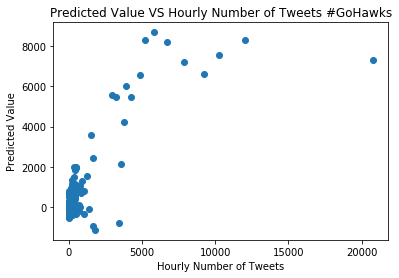

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


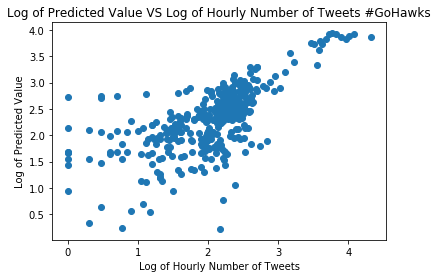

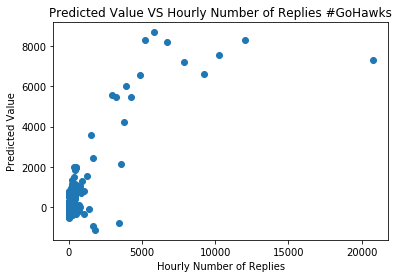

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10


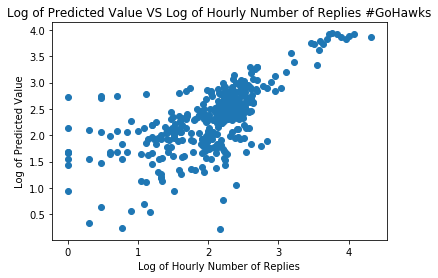

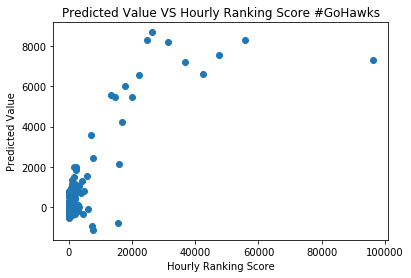

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log10


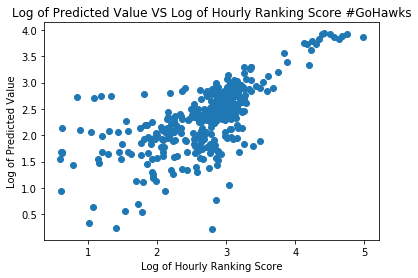

In [43]:
get_data_and_do_everything('#GoHawks')

RMSE is: 111.228920322
                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     113.0
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          7.92e-217
Time:                        01:33:46   Log-Likelihood:                -3525.1
No. Observations:                 575   AIC:                             7116.
Df Residuals:                     542   BIC:                             7260.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

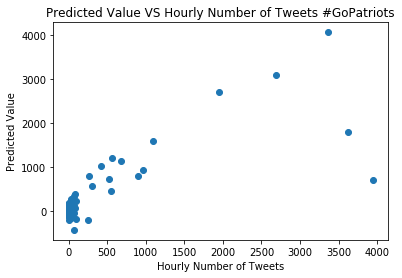

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


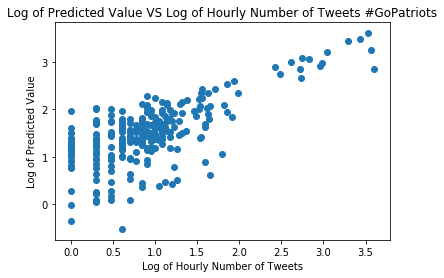

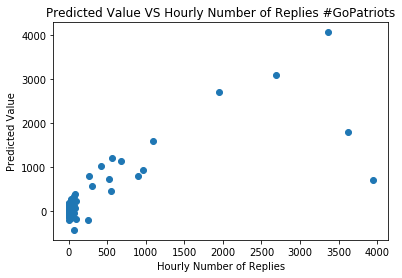

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10


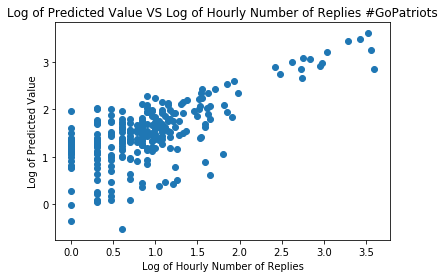

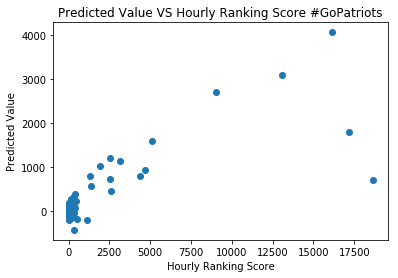

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log10


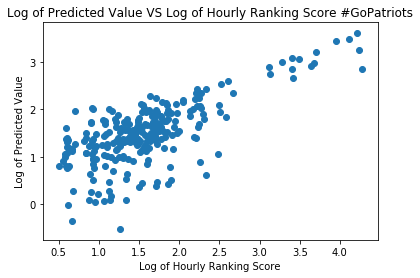

In [44]:
get_data_and_do_everything('#GoPatriots')

RMSE is: 444.829351596
                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     50.47
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          4.04e-142
Time:                        01:34:20   Log-Likelihood:                -4412.3
No. Observations:                 587   AIC:                             8891.
Df Residuals:                     554   BIC:                             9035.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

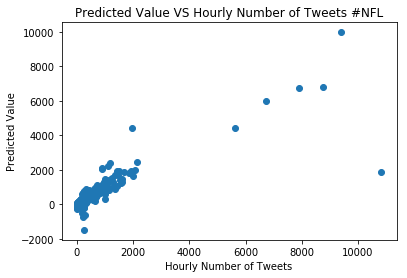

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


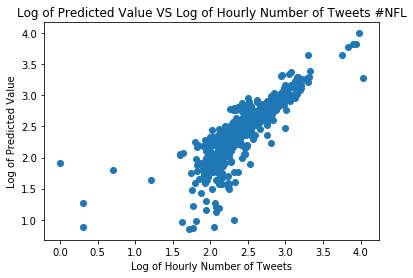

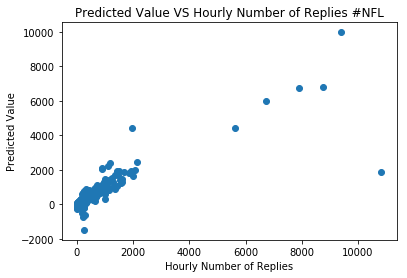

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10


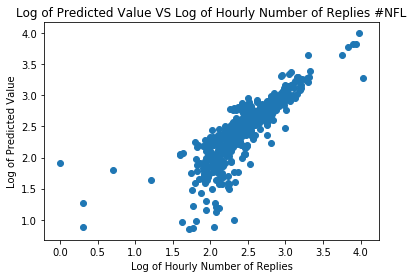

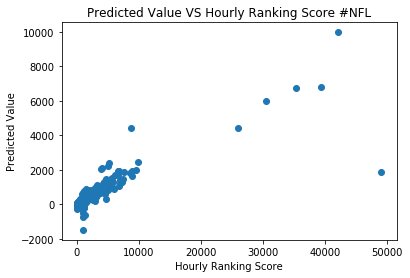

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log10


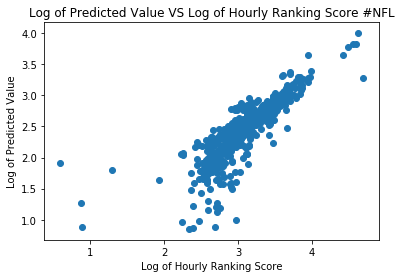

In [45]:
get_data_and_do_everything('#NFL')

RMSE is: 1853.36895721
                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     79.86
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          7.99e-185
Time:                        01:35:22   Log-Likelihood:                -5247.4
No. Observations:                 587   AIC:                         1.056e+04
Df Residuals:                     554   BIC:                         1.071e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

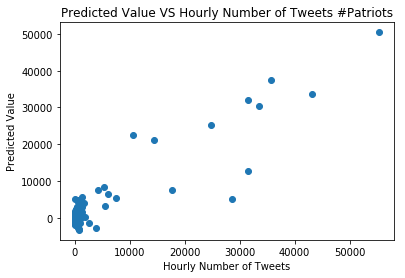

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


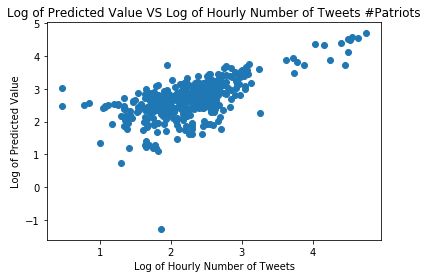

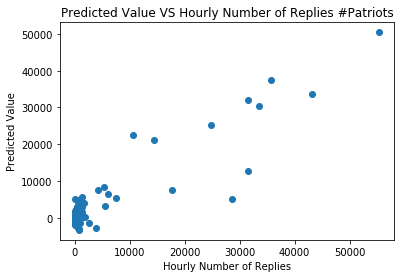

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10


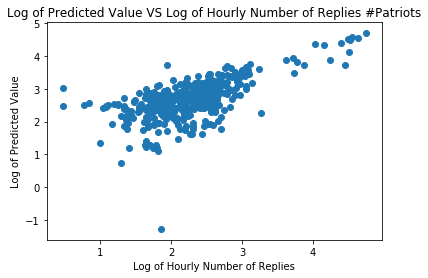

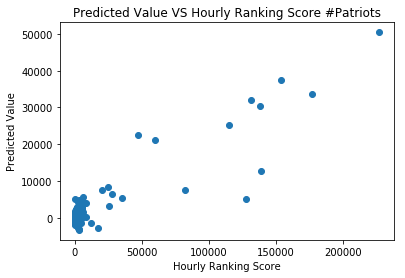

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log10


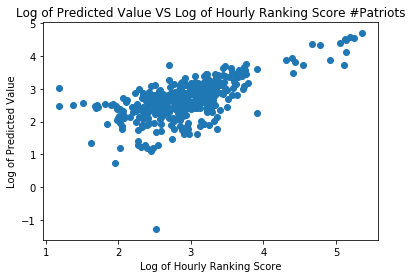

In [46]:
get_data_and_do_everything('#Patriots')

RMSE is: 3126.0141115
                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     159.9
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          2.88e-255
Time:                        01:37:05   Log-Likelihood:                -5518.9
No. Observations:                 583   AIC:                         1.110e+04
Df Residuals:                     550   BIC:                         1.125e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

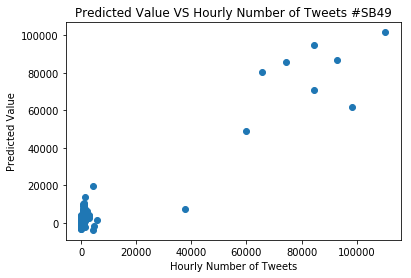

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


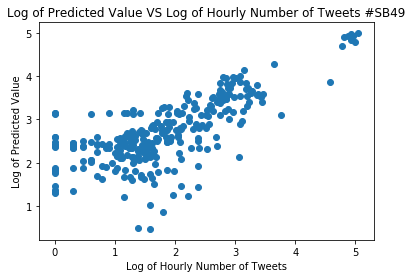

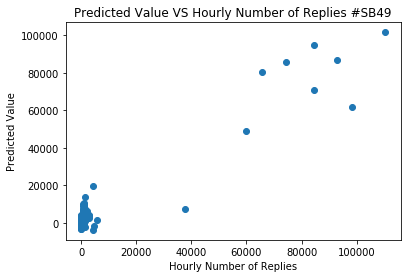

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10


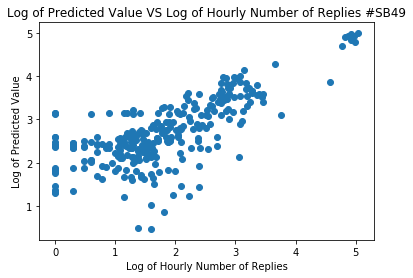

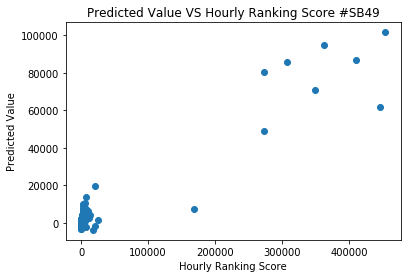

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log10


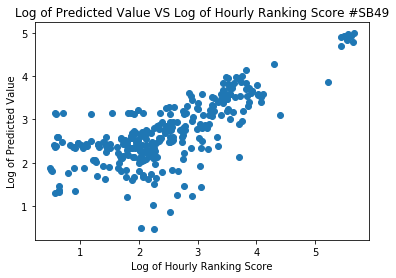

In [47]:
get_data_and_do_everything('#SB49')

RMSE is: 5382.63215391
                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     173.0
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          1.05e-264
Time:                        01:39:51   Log-Likelihood:                -5865.8
No. Observations:                 586   AIC:                         1.180e+04
Df Residuals:                     553   BIC:                         1.194e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

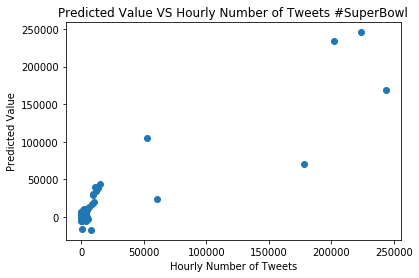

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


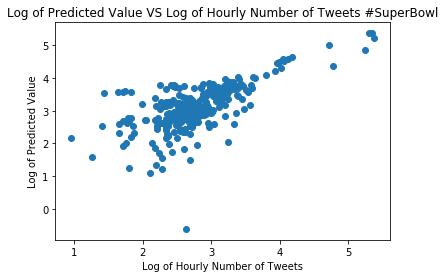

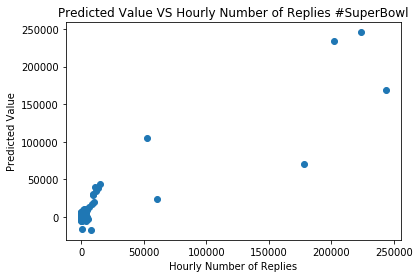

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10


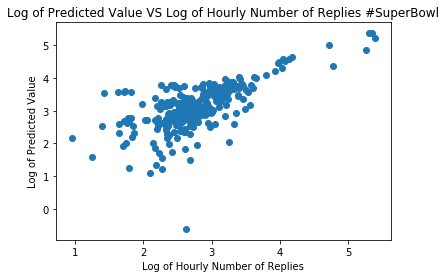

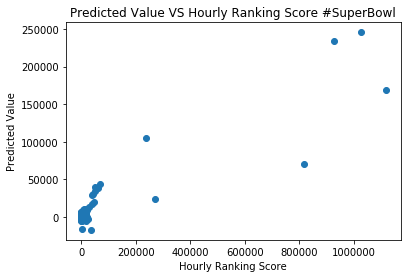

/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/ashwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log10


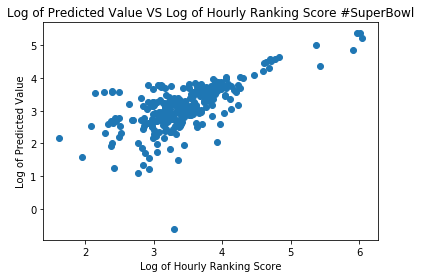

In [48]:
get_data_and_do_everything('#SuperBowl')

As can be seen in the graphs above, most of them have relatively linear relationships meaninign that we have chosen good features. Also, all of the graphs for each # are very similar shape meaning that these are actually important features which have been predicted similarly. 